# Queue Model (M/M/c/K) Analysis with PyDASA

This notebook demonstrates **dimensional analysis** of queueing systems using PyDASA's workflows with a custom dimensional framework. We'll explore how to:

1. Define a custom dimensional framework (Time, Structure, Data)
2. Model software service variables with custom dimensions
3. Use PyDASA's `AnalysisEngine` to derive dimensionless groups
4. Understand the M/M/c/K queue model and operational metrics
5. Perform sensitivity analysis and Monte Carlo simulation
6. Visualize the "Yoly" trade-off chart for system design

## What is the M/M/c/K Queue Model?

The **M/M/c/K** queue model is a fundamental queueing system in performance analysis:

- **M** (Markovian arrivals): Request arrivals follow a Poisson process with rate $\lambda$
- **M** (Markovian service): Service times follow exponential distribution with rate $\mu$
- **c**: Number of parallel servers (resources) available
- **K**: Maximum system capacity (queue + servers)

### Key Performance Metrics:

**Average Waiting Time** ($W$):
$$
W = f(\lambda, \mu, c, K, L, ...)
$$

**Traffic Intensity** ($\tau$):
$$
\tau = \frac{\lambda}{\mu}
$$

**System Utilization** ($\rho$):
$$
\rho = \frac{\lambda}{c \cdot \mu}
$$

### Error Rate and Effective Response

The system has an error rate ($err$) that affects the effective response rate:
$$
\chi = (1 - err) \cdot \lambda
$$

Where:
- $\chi$ (chi): Effective response rate accounting for errors [S/T]
- $err$: Error/failure rate [dimensionless, 0 to 1]
- $\lambda$: Arrival rate [S/T]

**Example**: If $\lambda = 100$ req/s and $err = 0.02$ (2% error rate), then $\chi = 0.98 \times 100 = 98$ req/s successfully served.

### Custom Dimensional Framework (T, S, D)

For software service analysis, we introduce three fundamental dimensions:
- **T** (Time): Temporal measurements [seconds]
- **S** (Structure): Capacity, servers, queue slots [units]
- **D** (Data): Information content, memory [bytes]

### The "Yoly" Concept

**Yoly** is a composite happiness metric that captures the trade-off between:
- **Performance**: Fast response times (low $W$)
- **Availability**: Low utilization (prevents saturation)
- **Memory Efficiency**: Optimal buffer allocation
- **Reliability**: Low error rates (high $\chi/\lambda$ ratio)

A high Yoly score indicates a well-balanced system configuration that keeps users happy!

## 1. Import Required Libraries

First, let's import PyDASA's core modules for dimensional analysis with custom frameworks.

In [15]:
# PyDASA imports
import pydasa
from pydasa.workflows.phenomena import AnalysisEngine
from pydasa.elements.parameter import Variable
from pydasa.dimensional.vaschy import Schema

# For visualization and analysis
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
import random


print(f"VERSION: {pydasa.__version__}")
print("PyDASA imported successfully!")

VERSION: 0.6.9
PyDASA imported successfully!


## 2. Define Custom Dimensional Framework

For software service analysis, we need a custom dimensional framework that captures the unique characteristics of queueing systems. Unlike physical systems (Length, Mass, Time), we define the following fundamental dimensional units:

**Custom Framework Definition:**

1. **T (Time)**: Temporal measurements
   - Unit: seconds [s].
   - Examples: waiting time, service time, inter-arrival time.
   - Physical analogy: Similar to Time in PHYSICAL framework.

2. **S (Structure)**: System capacity and architectural elements
   - Unit: requests [req].
   - Examples: number of servers, queue positions, concurrent requests.
   - Software-specific: Represents discrete structural resources.

3. **D (Data)**: Information content and memory.
   - Unit: bit [bit].
   - Examples: request payload size, buffer memory, data throughput.
   - Software-specific: Quantifies information processing.

This framework allows us to perform dimensional analysis on software services, deriving dimensionless numbers that characterize system behavior independent of scale.

In [16]:
# Define custom Fundamental Dimensional Units (FDUs) for software service analysis
fdu_list = [
    {
        "_idx": 0,
        "_sym": "T",
        "_fwk": "CUSTOM",
        "description": "Temporal measurements",
        "_unit": "s",
        "_name": "Time"
    },
    {
        "_idx": 1,
        "_sym": "S",
        "_fwk": "CUSTOM",
        "description": "System capacity and structural resources",
        "_unit": "units",
        "_name": "Structure"
    },
    {
        "_idx": 2,
        "_sym": "D",
        "_fwk": "CUSTOM",
        "description": "Information content and memory",
        "_unit": "bytes",
        "_name": "Data"
    }
]

# Create custom schema with T, S, D framework
schema = Schema(_fwk="CUSTOM",
                _fdu_lt=fdu_list, _idx=0)   # type: ignore
schema._setup_fdus()

print("=== Custom Framework Created Successfully! ===")
print(f"\tFramework: {schema.fwk}")
print(f"\tNumber of FDUs: {len(schema._fdu_lt)}")
print("\nFundamental Dimensional Units:")
print(f"{'Symbol':<10} {'Name':<15} {'Unit':<10} {'Description':<55}")
print("-" * 80)
for fdu in schema._fdu_lt:
    print(f"{fdu._sym:<10} {fdu._name:<15} {fdu._unit:<10} {fdu.description[:60]}")

=== Custom Framework Created Successfully! ===
	Framework: CUSTOM
	Number of FDUs: 3

Fundamental Dimensional Units:
Symbol     Name            Unit       Description                                            
--------------------------------------------------------------------------------
T          Time            s          Temporal measurements
S          Structure       units      System capacity and structural resources
D          Data            bytes      Information content and memory


## 3. Define Queue Model Variables

We'll define 10 variables for the M/M/c/K queueing system with proper dimensions using the custom T, S, D framework.

**Variable Categories:**

**INPUT Variables (3)** - Primary system parameters:
1. **λ** (lambda): Arrival rate [S/T].
2. **K**: Maximum queue capacity [S].
3. **ρ_req**: Data density per request [D/S].

**OUTPUT Variable (1)** - Performance metric we want to analyze:
1. **W**: Average waiting time [T].

**CONTROL Variables (6)** - System configuration and secondary parameters:
1. **L**: Average queue length [S].
2. **μ** (mu): Service rate [S/T].
3. **c**: Number of parallel servers [S].
4. **B**: Buffer allocated memory [D].
5. **err**: Error/failure rate [n.a.].
6. **χ** (chi): Effective response rate [S/T], where χ = (1 - err) × λ.

**Typical Values for a Web Service:**
- Arrival rate: 100 req/s.
- Service rate: 200 req/s for slow servers, 500 req/s for mid-tier servers, 1000 req/s for fast servers.
- Servers: up to 4 parallel processors.
- Queue capacity: 10 requests.
- Buffer memory: 23 MB.
- Data per request: 1 MB.
- Error rate: 1% (0.01).
- Average queue length: 3 requests.
- Waiting time: 50 ms.

In [17]:
# Define the queueing system variables as dictionaries
# Each variable is stored with its symbol as the key

variables_dict = {
    # INPUT VARIABLES (3)
    # Arrival rate: λ [S/T] - requests arriving per unit time
    "\\lambda_{s}": {
        "_idx": 0,
        "_sym": "\\lambda_{s}",
        "_alias": "lambda_s",
        "_fwk": "CUSTOM",
        "_cat": "IN",
        "_name": "Arrival Rate",
        "description": "Request arrival rate (Poisson process)",
        "relevant": True,
        "_dims": "S*T^-1",
        "_units": "req/s",
        "_setpoint": 100.0,     # req/s
        "_std_setpoint": 100.0,
        "_std_mean": 100.0,
        "_std_min": 100.0,
        "_std_max": 500.0,
        "_step": 10.0,
    },

    # Queue capacity: K [S] - maximum system capacity
    "K": {
        "_idx": 1,
        "_sym": "K",
        "_alias": "K",
        "_fwk": "CUSTOM",
        "_cat": "IN",
        "_name": "Queue Efective-Utility",
        "description": "Maximum system capacity (queue + servers)",
        "relevant": True,
        "_dims": "S",
        "_units": "requests",
        "_setpoint": 10.0,      # requests
        "_std_setpoint": 10.0,
        "_std_mean": 10.0,
        "_std_min": 8.0,
        "_std_max": 12.0,
        "_step": 1.0,
    },
    # Data density: ρ_req [D/S] - data per request
    "\\rho_{req}": {
        "_idx": 2,
        "_sym": "\\rho_{req}",
        "_alias": "rho_req",
        "_fwk": "CUSTOM",
        "_cat": "IN",
        "_name": "Data Density",
        "description": "Data content per request",
        "relevant": True,
        "_dims": "D*S^-1",
        "_units": "MB/req",
        "_setpoint": 1.0,           # 1 MB per request
        "_min": 0.001,              # 1 kB per request
        "_max": 10.0,               # 10 MB per request
        "_std_units": "bit/req",
        "_std_setpoint": 8000000,
        "_std_mean": 8000000.0,
        "_std_min": 8000,
        "_std_max": 80000000,
        "_step": 5*8000,           # 5 kbit steps in std units
    },

    # OUTPUT VARIABLE (1)
    # Queue length: L [S] - average number in queue
    "L": {
        "_idx": 4,
        "_sym": "L",
        "_alias": "L",
        "_fwk": "CUSTOM",
        "_cat": "OUT",
        "_name": "Queue Length",
        "description": "Average queue length",
        "relevant": True,
        "_dims": "S",
        "_units": "requests",
        "_setpoint": 0.9946,        # req, depends on M/M/c/K parameters
        "_std_setpoint": 0.9946,
        "_std_min": 0.9946,
        "_std_max": 4.9750,
        "_std_mean": 0.9946,
    },
    
    # Waiting time: W [T] - average time in queue
    "W": {
        "_idx": 3,
        "_sym": "W",
        "_alias": "W",
        "_fwk": "CUSTOM",
        "_cat": "CTRL",
        "_name": "Waiting Time",
        "description": "Average waiting time in queue",
        "relevant": True,
        "_dims": "T",
        "_units": "ms",
        "_setpoint": 5.0,         # waiting time, depends on M/M/c/K parameters
        "_std_min": 5.0,
        "_std_max": 13.7,
        "_std_units": "s",
        "_std_setpoint": 0.0050,
        "_std_mean": 0.0050,
        "_std_min": 0.0050,
        "_std_max": 0.0137,
    },

    # Service rate: μ [S/T] - requests served per unit time
    "\\mu_{s}": {
        "_idx": 5,
        "_sym": "\\mu_{s}",
        "_alias": "mu_comp",
        "_fwk": "CUSTOM",
        "_cat": "CTRL",
        "_name": "Service Rate",
        "description": "Service completion rate per server",
        "relevant": True,
        "_dims": "S*T^-1",
        "_units": "req/s",
        "_setpoint": 400.0,        # req/s, constant
        "_std_units": "req/s",
        "_std_setpoint": 500.0,
        "_std_mean": 400.0,
        "_std_min": 200.0,
        "_std_max": 1000.0,
    },

    # Response rate: χ [S/T] - effective throughput
    "\\chi_{s}": {
        "_idx": 9,
        "_sym": "\\chi_{s}",
        "_alias": "chi_comp",
        "_fwk": "CUSTOM",
        "_cat": "CTRL",
        "_name": "Response Rate",
        "description": "Effective response rate: χ = (1 - err) × λ",
        "relevant": True,
        "_dims": "S*T^-1",
        "_units": "req/s",
        "_setpoint": 97.0,         # (1 - 0.03) × 100 = 97 req/s, depends on error rate and arrival rate
        "_std_units": "req/s",
        "_std_setpoint": 97.0,
        "_std_min": 97.0,          # min: (1 - 0.03) × 100
        "_std_max": 485.0,         # max: (1 - 0.03) × 500
    },

    # Servers: c [S] - number of parallel servers
    "c": {
        "_idx": 6,
        "_sym": "c",
        "_alias": "c",
        "_fwk": "CUSTOM",
        "_cat": "CTRL",
        "_name": "Servers",
        "description": "Number of parallel requests handled by servers/processors",
        "relevant": True,
        "_dims": "S",
        "_units": "req",
        "_setpoint": 1.0,           # 1 request (1 server)
        "_std_units": "req",
        "_std_setpoint": 1.0,
        "_std_min": 1.0,
        "_std_max": 4.0,            # up to 8 servers (for scaling analysis)
        "_std_mean": 2.0,
    },

    # Buffer memory: B [D] - allocated memory
    "B": {
        "_idx": 7,
        "_sym": "B",
        "_alias": "B",
        "_fwk": "CUSTOM",
        "_cat": "CTRL",
        "_name": "Buffer Memory",
        "description": "Total allocated buffer memory",
        "relevant": True,
        "_dims": "D",
        "_units": "MB",
        "_setpoint": 16,            # 16 MB
        "_min": 16,
        "_max": 32,
        "_std_units": "bit",
        "_std_setpoint": 1.28e8,    # 128 Mb
        "_std_mean": 1.28e8,    # 128 Mb
        "_std_min": 1.28e8,         # 128 Mb
        "_std_max": 2.56e8,         # 256 Mb, (for scaling analysis)
    },

    # Error rate: err [dimensionless] - failure probability
    # NOT relevant for dimensional analysis (just a coefficient)
    "err": {
        "_idx": 8,
        "_sym": "err",
        "_alias": "err",
        "_fwk": "CUSTOM",
        "_cat": "CTRL",
        "_name": "Error Rate",
        "description": "Request error/failure rate (0 to 1)",
        "relevant": False,         # NOT part of dimensional matrix
        "_dims": "n.a.",               # Dimensionless
        "_units": "%",
        "_setpoint": 0.03,         # 3% error rate, constant
        "_std_units": "",
        "_std_setpoint": 0.03,
        "_std_min": 0.01,
        "_std_max": 0.04,
        "_std_mean": 0.03,
    },
}

# Q(M/M/c/K) queueing system variables:
# - λ: Arrival rate (S/T) = 200
# - K: Queue capacity (S) = 10
# - c: Servers (S) = 1
# - μ: Service rate (S/T) = 400
# - ρ_req: Data density (D/S) = 1 MB/req
# - B: Buffer memory (D) = 16 MB
# - err: Error rate (dimensionless) = 0.03 (3% failure rate)
# - χ: Response rate (S/T) = 97 req/s (calculated as (1 - err) × λ)
# Outputs (calculated from M/M/c/K formulas and error rate):
# - W: Waiting time (T) = 0.005 s
# - L: Queue length (S) = 0.9946 req
# - Wq: Waiting time in queue (T) = 0.0025 s
# - Lq: Queue length in queue (S) = 0.4949 req

# Convert dictionaries to Variable instances
variables = {
    sym: Variable(**params) for sym, params in variables_dict.items()
}

print("=== Variables defined ===")
print(f"\t- Total: {len(variables)}")
print(f"\t- Relevant for dimensional analysis: {sum(1 for v in variables.values() if v.relevant)}")
print(f"\t- Not relevant variables: {sum(1 for v in variables.values() if not v.relevant)}")

print("\nVariable Details:")
print(f"{'Symbol':<15} {'Setpoint':<20} {'Units':<10} {'Dimensions':<20} {'Category':<10} {'Relevant':<10}")
print("-" * 95)
for sym, var in variables.items():
    dims_str = var.dims if var.dims else "(N.A.)"
    relevant_str = "OK" if var.relevant else "ERROR"
    print(f"{sym:<15} {var.setpoint:<20} {var.units:<10} {dims_str:<20} {var.cat:<10} {relevant_str:<10}")

=== Variables defined ===
	- Total: 10
	- Relevant for dimensional analysis: 9
	- Not relevant variables: 1

Variable Details:
Symbol          Setpoint             Units      Dimensions           Category   Relevant  
-----------------------------------------------------------------------------------------------
\lambda_{s}     100.0                req/s      S*T^-1               IN         OK        
K               10.0                 requests   S                    IN         OK        
\rho_{req}      1.0                  MB/req     D*S^-1               IN         OK        
L               0.9946               requests   S                    OUT        OK        
W               5.0                  ms         T                    CTRL       OK        
\mu_{s}         400.0                req/s      S*T^-1               CTRL       OK        
\chi_{s}        97.0                 req/s      S*T^-1               CTRL       OK        
c               1.0                  req        S

## 3. Create Dimensional Analysis Engine

Now we'll use PyDASA's **AnalysisEngine** (main workflow) to automatically derive dimensionless groups using the Buckingham Pi theorem.

In [18]:
# Create the dimensional analysis engine
engine = AnalysisEngine(
    _idx=0,
    _fwk="CUSTOM",
    _schema=schema,
    _name="Software Service Analysis",
    description="Dimensional analysis for the Yoly Chart and the queue model M/M/c/K."
)

# Add all variables to the engine
engine.variables = variables

print("=== AnalysisEngine Created ===")
print(f"\t- Framework: {engine.fwk}")
print(f"\t- Variables: {len(variables)}\n")

print("Variable Categories:")
print("-" * 50)
n_inputs = sum(1 for v in variables.values() if v.cat == "IN")
print(f"\t- Input variables: {n_inputs}")
n_outputs = sum(1 for v in variables.values() if v.cat == "OUT")
print(f"\t- Output variables: {n_outputs}")
n_controls = sum(1 for v in variables.values() if v.cat == "CTRL")
print(f"\t- Control variables: {n_controls}")

=== AnalysisEngine Created ===
	- Framework: CUSTOM
	- Variables: 10

Variable Categories:
--------------------------------------------------
	- Input variables: 3
	- Output variables: 1
	- Control variables: 6


## 4. Run Dimensional Analysis

Execute the complete workflow to generate dimensionless coefficients (Pi groups).

In [19]:
# Run the complete dimensional analysis workflow
results = engine.run_analysis()

print(f"=== Analysis complete! ===")
print(f"\tNumber of Dimensionless Groups: {len(engine.coefficients)}")
print(f"\tCoefficients generated: {list(engine.coefficients.keys())}\n")

# Display coefficients in a formatted table
print("Dimensionless Coefficients Details:")
print("=" * 100)
print(f"{'Coefficient':<15} {'Expression':<35} {'Variable Exponents':<60}")
print("=" * 100)

for name, coeff in engine.coefficients.items():
    # Extract the coefficient expression
    expression = str(coeff.pi_expr) if len(str(coeff.pi_expr)) < 35 else str(coeff.pi_expr)[:32] + "..."
    
    # Format variable exponents as a compact string
    exponents_str = ", ".join([f"{var}^{exp}" if exp != 1 else var
                               for var, exp in coeff.var_dims.items()])
    if len(exponents_str) > 58:
        exponents_str = exponents_str[:55] + "..."
    
    print(f"{name:<15} {expression:<35} {exponents_str:<60}")

print("=" * 100)

=== Analysis complete! ===
	Number of Dimensionless Groups: 6
	Coefficients generated: ['\\Pi_{0}', '\\Pi_{1}', '\\Pi_{2}', '\\Pi_{3}', '\\Pi_{4}', '\\Pi_{5}']

Dimensionless Coefficients Details:
Coefficient     Expression                          Variable Exponents                                          
\Pi_{0}         \frac{L}{K}                         K^-1, L                                                     
\Pi_{1}         \frac{\lambda_{s}*W}{K}             \lambda_{s}, K^-1, W                                        
\Pi_{2}         \frac{\mu_{s}}{\lambda_{s}}         \lambda_{s}^-1, \mu_{s}                                     
\Pi_{3}         \frac{\chi_{s}}{\lambda_{s}}        \lambda_{s}^-1, \chi_{s}                                    
\Pi_{4}         \frac{c}{K}                         K^-1, c                                                     
\Pi_{5}         \frac{B}{K*\rho_{req}}              K^-1, \rho_{req}^-1, B                                      


## 5. Derive Key Dimensionless Coefficients

Now let's use PyDASA's `derive_coefficient()` method to create operationally meaningful coefficients from the Pi groups. Thus, we expect to see:

1. **Occupancy Coefficient (σ)**: Queue capacity utilization - σ = Π₀ = L/K
2. **Stall Coefficient (δ)**: Service blocking indicator - δ = Π₁ = W·λ/L
3. **Efective-Utility Coefficient (η)**: Resource utilization effectiveness - η = Π₂⁻¹·Π₃·Π₄⁻¹ = χ·K/(μ·c)
4. **Payload Coefficient (φ)**: Data density metric - φ = Π₅ = B/(ρ_req·K)

These derived coefficients connect directly to the Yoly diagram we'll construct.

In [20]:
# Get the original Pi coefficients
pi_keys = list(engine.coefficients.keys())

# Derive Occupancy Coefficient: δ = Π₀ = L/K
delta_coeff = engine.derive_coefficient(
    expr=f"{pi_keys[0]}",
    symbol="\\delta",
    name="Occupancy Coefficient",
    description="δ = L/K - Queue occupancy ratio (0 = empty, 1 = full)",
    idx=-1
)

# Derive Stall Coefficient: σ = Π₁ = W·λ/L
sigma_coeff = engine.derive_coefficient(
    expr=f"{pi_keys[1]}",
    symbol="\\sigma",
    name="Stall Coefficient",
    description="σ = W·λ/L - Service stall/blocking indicator",
    idx=-1
)

# Derive Efective-Utility Coefficient: η = Π₂⁻¹·Π₃·Π₄⁻¹ = χ·K/(μ·c)
eta_coeff = engine.derive_coefficient(
    # expr=f"{pi_keys[2]} * {pi_keys[3]}**(-1) * {pi_keys[4]}",
    expr=f"{pi_keys[2]}**(-1) * {pi_keys[3]} * {pi_keys[4]}**(-1)",
    symbol="\\eta",
    name="Efective-Utility Coefficient",
    description="η = χ·K/(μ·c) - Resource utilization effectiveness",
    idx=-1
)

# Derive Payload Coefficient: φ = Π₅ = B/(ρ_req·K)
phi_coeff = engine.derive_coefficient(
    expr=f"{pi_keys[5]}",
    symbol="\\phi",
    name="Payload Coefficient",
    description="φ = B/(ρ_req·K) - Data density metric",
    idx=-1
)

# Calculate numerical values using stored setpoints
delta_val = delta_coeff.calculate_setpoint()
sigma_val = sigma_coeff.calculate_setpoint()
eta_val = eta_coeff.calculate_setpoint()
phi_val = phi_coeff.calculate_setpoint()

# Display results
print("=" * 120)
print("DERIVED DIMENSIONLESS COEFFICIENTS")
print("=" * 120)
print(f"{'Coefficient':<25} {'Expression':<45} {'Value':<15} {'Description':<35}")
print("=" * 120)
print(f"{'Occupancy (δ)':<25} {str(delta_coeff.pi_expr):<45} {delta_val:<15.4f} {'Queue capacity utilization':<35}")
print(f"{'Stall (σ)':<25} {str(sigma_coeff.pi_expr)[:45]:<45} {sigma_val:<15.4f} {'Service blocking indicator':<35}")
print(f"{'Efective-Utility (η)':<25} {str(eta_coeff.pi_expr)[:45]:<45} {eta_val:<15.4f} {'Resource utilization':<35}")
print(f"{'Payload (φ)':<25} {str(phi_coeff.pi_expr):<45} {phi_val:<15.4f} {'Data density metric':<35}")
print("=" * 120)

# Interpret values for operational insights
print("\nTRADITIONAL QUEUE OPERATIONAL ASSESSMENT")
print("=" * 120)

# traffic intensity: t = λ/μ
lambda_s = variables["\\lambda_{s}"].setpoint
mu_s = variables["\\mu_{s}"].setpoint
theta = lambda_s / mu_s    # type: ignore
print(f"Traffic Intensity (θ = λ/μ) = {theta:.2f}")

# utilization: ρ = λ/(c·μ)
c = variables["c"].setpoint
rho = lambda_s / (c* mu_s)    # type: ignore
print(f"Utilization (ρ = λ/(c·μ)) = {rho:.2f}")

# Occupancy L/K
L = variables["L"].setpoint
K = variables["K"].setpoint
occupancy = L / K    # type: ignore
print(f"Occupancy (L/K) = {occupancy:.4f}")

DERIVED DIMENSIONLESS COEFFICIENTS
Coefficient               Expression                                    Value           Description                        
Occupancy (δ)             \frac{L}{K}                                   0.0995          Queue capacity utilization         
Stall (σ)                 \frac{\lambda_{s}*W}{K}                       0.0500          Service blocking indicator         
Efective-Utility (η)      \frac{K*\chi_{s}}{\mu_{s}*c}                  1.9400          Resource utilization               
Payload (φ)               \frac{B}{K*\rho_{req}}                        1.6000          Data density metric                

TRADITIONAL QUEUE OPERATIONAL ASSESSMENT
Traffic Intensity (θ = λ/μ) = 0.25
Utilization (ρ = λ/(c·μ)) = 0.25
Occupancy (L/K) = 0.0995


## 7. Sensitivity Analysis

Let's use PyDASA's **SensitivityAnalysis** workflow to understand which variables have the most influence on our dimensionless coefficients.

In [21]:
from pydasa.workflows.influence import SensitivityAnalysis

# Create sensitivity analysis handler
sensitivity = SensitivityAnalysis(
    _idx=0,
    _fwk="CUSTOM",
    _schema=schema,
    _name="Queue Model Sensitivity Analysis",
    _cat="SYM"  # Symbolic sensitivity analysis
)

# Configure with variables and coefficients from the engine
sensitivity.variables = engine.variables
sensitivity.coefficients = engine.coefficients

print("=== SensitivityAnalysis workflow created ===")
print(f"\tFramework: {sensitivity.fwk}")
print(f"\tAnalysis type: {sensitivity.cat} (Symbolic)")
print(f"\tVariables: {len(sensitivity.variables)}")
print(f"\tCoefficients to analyze: {len(sensitivity.coefficients)}")

# Run symbolic sensitivity analysis at mean values
print("\n--- Running Symbolic Sensitivity Analysis ---")
sensitivity_results = sensitivity.analyze_symbolic(val_type="mean")

print(f"=== Symbolic sensitivity analysis complete! ===")
print(f"\tAnalyzed {len(sensitivity_results)} coefficients")
print(f"\tResults available for: {list(sensitivity_results.keys())}")

=== SensitivityAnalysis workflow created ===
	Framework: CUSTOM
	Analysis type: SYM (Symbolic)
	Variables: 10
	Coefficients to analyze: 10

--- Running Symbolic Sensitivity Analysis ---
=== Symbolic sensitivity analysis complete! ===
	Analyzed 10 coefficients
	Results available for: ['SEN_{\\Pi_{0}}', 'SEN_{\\Pi_{1}}', 'SEN_{\\Pi_{2}}', 'SEN_{\\Pi_{3}}', 'SEN_{\\Pi_{4}}', 'SEN_{\\Pi_{5}}', 'SEN_{\\delta}', 'SEN_{\\sigma}', 'SEN_{\\eta}', 'SEN_{\\phi}']


In [22]:
# Display sensitivity analysis results in formatted tables
print("=" * 120)
print("SENSITIVITY ANALYSIS RESULTS - Symbolic Differentiation at Mean Values")
print("=" * 120)

# Get the derived coefficients we care about (σ, δ, η, φ)
derived_coeff_keys = [
    k for k in sensitivity_results.keys() if not k.startswith("SEN_{\\Pi")
]

for coeff_key in derived_coeff_keys:
    sens_data = sensitivity_results[coeff_key]
    
    # Get coefficient name
    if coeff_key in engine.coefficients:
        coeff_name = engine.coefficients[coeff_key].name
    else:
        coeff_name = coeff_key
    
    print(f"\n{'Coefficient':<25} {coeff_key:<20} ({coeff_name})")
    print("-" * 120)
    print(f"{'Variable':<20} {'Sensitivity':<20} {'Relative Impact (%)':<25} {'Description':<55}")
    print("-" * 120)
    
    # Calculate total sensitivity for relative percentages
    total_sens = sum(abs(v) for v in sens_data.values() if isinstance(v, (int, float)))
    
    # Sort by absolute sensitivity (descending)
    sorted_vars = sorted(sens_data.items(), key=lambda x: abs(x[1]) if isinstance(x[1], (int, float)) else 0, reverse=True)
    
    for var_sym, sens_val in sorted_vars:
        if isinstance(sens_val, (int, float)):
            # Get variable name
            if var_sym in engine.variables:
                var_name = engine.variables[var_sym].name
            else:
                var_name = var_sym
            
            # Calculate relative impact
            rel_impact = (abs(sens_val) / total_sens * 100) if total_sens > 0 else 0
            
            # Format sensitivity value
            sens_str = f"{sens_val:+.4e}"
            
            # Impact description
            if rel_impact > 40:
                impact_desc = "🔴 DOMINANT influence"
            elif rel_impact > 20:
                impact_desc = "🟠 MAJOR influence"
            elif rel_impact > 10:
                impact_desc = "🟡 MODERATE influence"
            else:
                impact_desc = "🟢 MINOR influence"
            
            print(f"{var_sym:<20} {sens_str:<20} {rel_impact:<25.2f} {impact_desc:<55}")

print("\n" + "=" * 120)

SENSITIVITY ANALYSIS RESULTS - Symbolic Differentiation at Mean Values

Coefficient               SEN_{\delta}         (SEN_{\delta})
------------------------------------------------------------------------------------------------------------------------
Variable             Sensitivity          Relative Impact (%)       Description                                            
------------------------------------------------------------------------------------------------------------------------
L                    +1.0000e-01          90.95                     🔴 DOMINANT influence                                   
K                    -9.9460e-03          9.05                      🟢 MINOR influence                                      

Coefficient               SEN_{\sigma}         (SEN_{\sigma})
------------------------------------------------------------------------------------------------------------------------
Variable             Sensitivity          Relative Impact (%)       

## 7. Grid-Based Monte Carlo Data Generation

Instead of random sampling, we'll generate structured data points by systematically varying queue parameters:

**Strategy**: Grid search over configurations while varying arrival rate (λ) until near-saturation

**Configuration Parameters**:
- **K** (Capacity) = [5, 10, 20] req → 3 values
- **μ** (Service rate): [200, 500, 1000] req/s → 3 values  
- **c** (Servers): [1, 2, 4] → 3 values
- **Total configurations**: 3 × 3 × 3 = **27 configurations**

**Constants**:
- **err** (Error rate): 0.01 (1% failure rate)
- **B** (Buffer) = 32 MB (fixed, equivalent to 1.28×10⁸ bits)
- **ρ_req** (Data density) = 1.0 MB/req (fixed, equivalent to 8×10⁶ bits/req)

**Lambda Sweep Strategy**:
- Start: λ_min = **100 req/s** (from std_min)
- Stop: When **ρ = λ/(c·μ) ≥ 0.95** (near-saturation, avoid instability)
- Step: Δλ = **10 req/s**

**For each configuration**, we'll:
1. Vary λ from 100 to saturation point (ρ ≥ 0.95)
2. Calculate χ = (1 - err) × λ
3. Use MMcK queueing model to compute W and L
4. Store all variable values for PyDASA analysis

In [29]:
from src.queueing import Queue
import itertools
import pandas as pd

# STEP A: Generate Configuration Grid
# ====================================
print("=" * 80)
print("STEP A: Generating Configuration Grid")
print("=" * 80)
# iterate over the following parameters:
# lambda_s: from 100 to overflow state

# for the grid-search we iterate over the following parameters:
# K: queue capacity wih 2, 5, 10, 20
# c: number of servers with 1, 2, 4
# mu: 200, 500 an 1000 for slow, medium and fast services

# the constants are:
# rho_req: 1 MB/req
# B: 32 MB
# err: 1% as 1 sigma QoS agreement.

# calculate the following values for the grid search:
# W: waiting time in queue
# L: queue length

K_values = [5, 10, 20]

c_values = [
    variables["c"].std_min,
    variables["c"].std_mean,
    variables["c"].std_max,
]

# lamba_zero: arrival rate starting point: 100 req/s
lambda_zero = variables["\\lambda_{s}"].std_min  # Arrival rate [req/s]
lambda_step = variables["\\lambda_{s}"].step     # Arrival rate step [req/s]

err_cst = variables["err"].std_min      # Error rate [%]

B_cst = variables["B"].std_setpoint  # Buffer memory [MB]

rho_req_cst = variables["\\rho_{req}"].std_setpoint  # Data density [bit/req]

mu_values = [
    variables["\\mu_{s}"].std_min,
    variables["\\mu_{s}"].std_setpoint,
    variables["\\mu_{s}"].std_max,
]

# Generate all combinations (Cartesian product)
cfg_lt = list(itertools.product(K_values, c_values, mu_values))
print(f"\nGenerated {len(cfg_lt)} configurations:")
print(f"{'Config #':<10} {'K (Capacity)':<15} {'c (Servers)':<15} {'μ (Service Rate)':<20}")
print("-" * 60)
for idx, (K_val, c_val, mu_val) in enumerate(cfg_lt):
    print(f"{idx:<10} {K_val:<15} {c_val:<15} {mu_val:<20}")

print(f"\n=== Configuration grid ready: {len(cfg_lt)} configurations ===")


print("=" * 80)
print("Simulation Constants:")
print("-" * 80)
print(f"\t- Buffer Memory (B): {B_cst} [bit]")
print(f"\t- Data Density (ρ_req): {rho_req_cst} [bit/req]")
print(f"\t- Error Rate (err): {err_cst * 100:.2f} [%]")      # type: ignore
print(f"\t- Arrival Rate (λ₀): {lambda_zero} [req/s]")
print(f"\t- Arrival Rate Step (Δλ): {lambda_step} [req/s]")

# STEP B: Create DataFrame for Queue Variables
# =============================================
print("\n" + "=" * 80)
print("STEP B: Creating Queue Model DataFrame")
print("=" * 80)

q_cols = list(variables.keys())
data_df = pd.DataFrame(columns=q_cols)
print(f"\t- DataFrame columns: {len(q_cols)} variables")
print(f"\t- Initial shape: {data_df.shape}")
print("=" * 80)

# STEP C: Generate Data Points with M/M/c/K Model
# ================================================
print("\n" + "=" * 80)
print("STEP C: Generating Data with M/M/c/K Queueing Model")
print("=" * 80)

RHO_THLD = 0.95  # Stop when utilization reaches 95.0%

# Process each configuration
for idx, (K, c, mu) in enumerate(cfg_lt, 1):
    print(f"\t--- Config {idx}/{len(cfg_lt)}: K={K}, c={c}, μ={mu} ---")
    lambda_t = lambda_zero
    rho_t = 0.0
    i = 0

    while rho_t < RHO_THLD:
        # Create and evaluate M/M/c/K queue model
        q = Queue(
            "M/M/s/K",
            _lambda=lambda_t,   # type: ignore
            mu=mu,              # type: ignore
            n_servers=c,        # type: ignore
            kapacity=K      # type: ignore
        )
        q.calculate_metrics()
        chi_t = lambda_t * (1 - err_cst)    # type: ignore

        # Store data point
        data_t = [
            lambda_t,
            K,
            rho_req_cst,
            q.avg_len,
            q.avg_wait,
            mu,
            chi_t,
            c,
            B_cst,
            err_cst,
        ]

        data_df.loc[len(data_df)] = data_t

        rho_t = q.rho
        lambda_t = lambda_t + lambda_step   # type: ignore
        i += 1

    print(f"\t- OK: Generated {i} data points for this configuration")

print("\n" + "=" * 80)
print("DATA GENERATION COMPLETE")
print("=" * 80)
print(f"\t- Total configurations: {len(cfg_lt)}")
print(f"\t- Total data points: {len(data_df)}")
print(f"\t- Average points per config: {len(data_df) / len(cfg_lt):.1f}")

print("\n" + "=" * 100)
print("DATA STATISTICS")
print("=" * 100)
print(data_df.describe())
print("=" * 100)

# STEP D: Add Data to PyDASA Variables
# =====================================
print("\n" + "=" * 80)
print("STEP D: Injecting Data into PyDASA Variables")
print("=" * 80)

data = data_df.to_dict(orient="list")
for sym, var in variables.items():
    if sym in data:
        var.data = data[sym]
        print(
            f"\t- OK: Added data to '{sym}' ({var.name}): {len(var.data)} points")
    else:
        print(f"\t- WARN: No data found for '{sym}' ({var.name})")

engine.variables = variables
print("\n- OK: All data successfully injected into PyDASA engine!")
print("=" * 80)

STEP A: Generating Configuration Grid

Generated 27 configurations:
Config #   K (Capacity)    c (Servers)     μ (Service Rate)    
------------------------------------------------------------
0          5               1.0             200.0               
1          5               1.0             500.0               
2          5               1.0             1000.0              
3          5               2.0             200.0               
4          5               2.0             500.0               
5          5               2.0             1000.0              
6          5               4.0             200.0               
7          5               4.0             500.0               
8          5               4.0             1000.0              
9          10              1.0             200.0               
10         10              1.0             500.0               
11         10              1.0             1000.0              
12         10              2.0         

In [30]:
# Create PyDASA MonteCarloSimulation with grid data
from pydasa.workflows.practical import MonteCarloSimulation

print("\n" + "=" * 80)
print("Creating PyDASA MonteCarloSimulation with Grid Data")
print("=" * 80)

# Create Monte Carlo handler
mc_grid = MonteCarloSimulation(
    _idx=0,
    _fwk="CUSTOM",
    _schema=schema,
    _name="Grid-Based Queue Analysis",
    _cat="DATA", # category o read the variable data
    _experiments=len(data_df),
    _variables=engine.variables,
    _coefficients=engine.coefficients
)

# Run the simulation
print("\nRunning Monte Carlo simulation...")
mc_grid.run_simulation(iters=len(data_df))

print("--- Monte Carlo simulation complete! ---")
print(f"\tExperiments run: {mc_grid.experiments}")
print(f"\tCoefficients analyzed: {list(mc_grid.simulations.keys())}")
print(f"\tResults available for: {list(mc_grid.results.keys())}")


Creating PyDASA MonteCarloSimulation with Grid Data

Running Monte Carlo simulation...
--- Monte Carlo simulation complete! ---
	Experiments run: 3150
	Coefficients analyzed: ['\\Pi_{0}', '\\Pi_{1}', '\\Pi_{2}', '\\Pi_{3}', '\\Pi_{4}', '\\Pi_{5}', '\\delta', '\\sigma', '\\eta', '\\phi']
	Results available for: ['\\Pi_{0}', '\\Pi_{1}', '\\Pi_{2}', '\\Pi_{3}', '\\Pi_{4}', '\\Pi_{5}', '\\delta', '\\sigma', '\\eta', '\\phi']


In [31]:
# Can extract simulation results from ORIGINAL Pi coefficients, or the derived values
# The Monte Carlo simulation ran with the original and derived derived coefficients

# Get the ORIGINAL Pi coefficient names
all_keys = list(mc_grid.simulations.keys())

# Filter to get only the original Pi coefficients (they start with \\Pi_)
pi_keys = [k for k in all_keys if k.startswith('\\Pi_')]
print(f"Original Pi coefficients in simulation: {pi_keys}")

# Also check for derived coefficients
derived_keys = [k for k in all_keys if not k.startswith('\\Pi_')]
print(f"Derived coefficients in simulation: {derived_keys}\n")

# Extract derived Pi coefficients
print("--- Extracting Derived Pi Coefficients from Simulation ---")
pi_data = {}
for pi_key in derived_keys:
    pi_sim_obj = mc_grid.get_simulation(pi_key)
    pi_results = pi_sim_obj.extract_results()
    # adding variables
    for sym, var in pi_sim_obj.variables.items():
        pi_data[sym] = var.data
    pi_data[pi_key] = pi_results[pi_key]
    print(f"\t{pi_key}: Mean = {np.mean(pi_data[pi_key]):.6e}, Range = [{np.min(pi_data[pi_key]):.6e}, {np.max(pi_data[pi_key]):.6e}]")

print("\n--- Computing Derived Coefficients from Pi Groups ---")

# Compute relevant derived coefficients
delta_sim = pi_data[derived_keys[0]]
print(f"Occupancy Coefficient, delta: Mean = {np.mean(delta_sim):.6e}")

sigma_sim = pi_data[derived_keys[1]]
print(f"Stall Coefficient, sigma: Mean = {np.mean(sigma_sim):.6e}")

eta_sim = pi_data[derived_keys[2]]
print(f"Efective-Utility Coefficient, eta: Mean = {np.mean(eta_sim):.6e}")

phi_sim = pi_data[derived_keys[3]]
print(f"Data Payload Coefficient, phi: Mean = {np.mean(phi_sim):.6e}\n")

# Display simulation statistics
print("=" * 100)
print("MONTE CARLO SIMULATION RESULTS - DERIVED COEFFICIENTS")
print("=" * 100)
print(f"{'Parameter':<30} {'Mean':<15} {'Std Dev':<15} {'Min':<15} {'Max':<15}")
print("=" * 100)
print(f"{'Occupancy Coefficient (δ)':<30} {np.mean(delta_sim):<15.6e} {np.std(delta_sim):<15.6e} {np.min(delta_sim):<15.6e} {np.max(delta_sim):<15.6e}")
print(f"{'Stall Coefficient (σ)':<30} {np.mean(sigma_sim):<15.6e} {np.std(sigma_sim):<15.6e} {np.min(sigma_sim):<15.6e} {np.max(sigma_sim):<15.6e}")
print(f"{'Efective-Utility Coefficient (η)':<30} {np.mean(eta_sim):<15.6e} {np.std(eta_sim):<15.6e} {np.min(eta_sim):<15.6e} {np.max(eta_sim):<15.6e}")
print(f"{'Data Payload Coefficient (φ)':<30} {np.mean(phi_sim):<15.6e} {np.std(phi_sim):<15.6e} {np.min(phi_sim):<15.6e} {np.max(phi_sim):<15.6e}") 
print("=" * 100)

Original Pi coefficients in simulation: ['\\Pi_{0}', '\\Pi_{1}', '\\Pi_{2}', '\\Pi_{3}', '\\Pi_{4}', '\\Pi_{5}']
Derived coefficients in simulation: ['\\delta', '\\sigma', '\\eta', '\\phi']

--- Extracting Derived Pi Coefficients from Simulation ---
	\delta: Mean = 2.221570e-01, Range = [5.000005e-03, 6.387088e-01]
	\sigma: Mean = 2.356849e-01, Range = [5.000005e-03, 8.152946e-01]
	\eta: Mean = 5.889895e+00, Range = [1.237500e-01, 1.900800e+01]
	\phi: Mean = 1.866667e+00, Range = [8.000000e-01, 3.200000e+00]

--- Computing Derived Coefficients from Pi Groups ---
Occupancy Coefficient, delta: Mean = 2.221570e-01
Stall Coefficient, sigma: Mean = 2.356849e-01
Efective-Utility Coefficient, eta: Mean = 5.889895e+00
Data Payload Coefficient, phi: Mean = 1.866667e+00

MONTE CARLO SIMULATION RESULTS - DERIVED COEFFICIENTS
Parameter                      Mean            Std Dev         Min             Max            
Occupancy Coefficient (δ)      2.221570e-01    1.677476e-01    5.000005e-03    

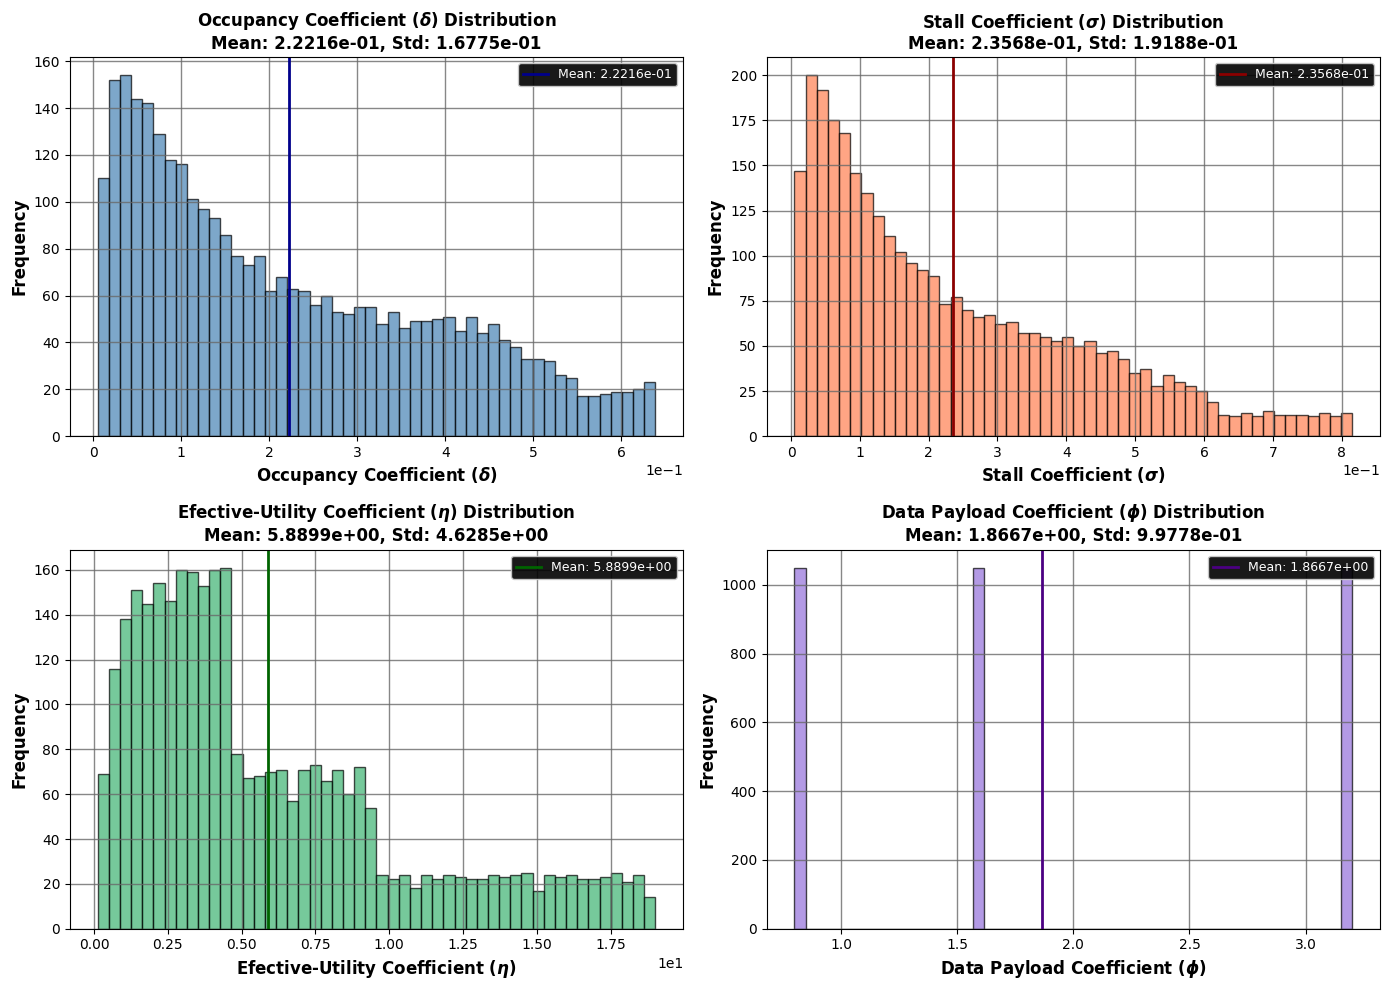

In [32]:
# Plot distributions of the four derived coefficients in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10), facecolor="white")

# Create auxiliary lists for iteration
coeff_data = [delta_sim, sigma_sim, eta_sim, phi_sim]
coeff_names = [
    r"Occupancy Coefficient ($\boldsymbol{\delta}$)", 
    r"Stall Coefficient ($\boldsymbol{\sigma}$)", 
    r"Efective-Utility Coefficient ($\boldsymbol{\eta}$)", 
    r"Data Payload Coefficient ($\boldsymbol{\phi}$)"
]
coeff_colors = ["steelblue", "coral", "mediumseagreen", "mediumpurple"]
mean_line_colors = ["darkblue", "darkred", "darkgreen", "indigo"]

# Iterate over grid positions (2x2)
plot_idx = 0
for row in range(2):
    for col in range(2):
        # Set white background for subplot
        axes[row, col].set_facecolor("white")
        
        # Get current data and properties
        data = coeff_data[plot_idx]
        name = coeff_names[plot_idx]
        color = coeff_colors[plot_idx]
        mean_color = mean_line_colors[plot_idx]
        
        # Plot histogram
        axes[row, col].hist(data, bins=50, color=color, alpha=0.7, edgecolor="black")
        
        # Add mean line
        axes[row, col].axvline(np.mean(data), color=mean_color, linestyle="-", linewidth=2,
                               label=f"Mean: {np.mean(data):.4e}")
        
        # Set labels and title with black font
        axes[row, col].set_xlabel(name, fontsize=12, fontweight="bold", color="black")
        axes[row, col].set_ylabel("Frequency", fontsize=12, fontweight="bold", color="black")
        title = f"{name} Distribution\nMean: {np.mean(data):.4e}, Std: {np.std(data):.4e}"
        axes[row, col].set_title(title, fontsize=12, fontweight="bold", color="black")
        
        # Format and style with black font
        axes[row, col].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        axes[row, col].tick_params(colors="black", which="both")
        axes[row, col].legend(loc="best", fontsize=9, framealpha=0.9)
        axes[row, col].grid(True, alpha=0.8, color="dimgray", linewidth=1.0)
        
        # Set spine colors to black
        for spine in axes[row, col].spines.values():
            spine.set_edgecolor("black")
        
        plot_idx += 1

plt.tight_layout()
plt.show()

## 9. Plot Yoly Diagram Using Grid-Based Data

Similar to the Moody diagram for Reynolds number, we can plot the relationship between **occupancy coefficient (δ)** and **stall coefficient (σ)** to visualize queue behavior across different configurations.

This plot shows:
- **X-axis**: δ (Occupancy = L/K) - Queue fullness ratio.
- **Y-axis**: σ (Stall = W·λ/L) - Service blocking probability.
- **Z-axis**: η (Efficiency = χ·K/(μ·c)) - Resource utilization effectiveness.
- **Color coding**: By number of servers (red=1, orange=2, yellow=4, green=8).

The relationship reveals how queue occupancy directly influences the probability of service stalls across different system configurations.

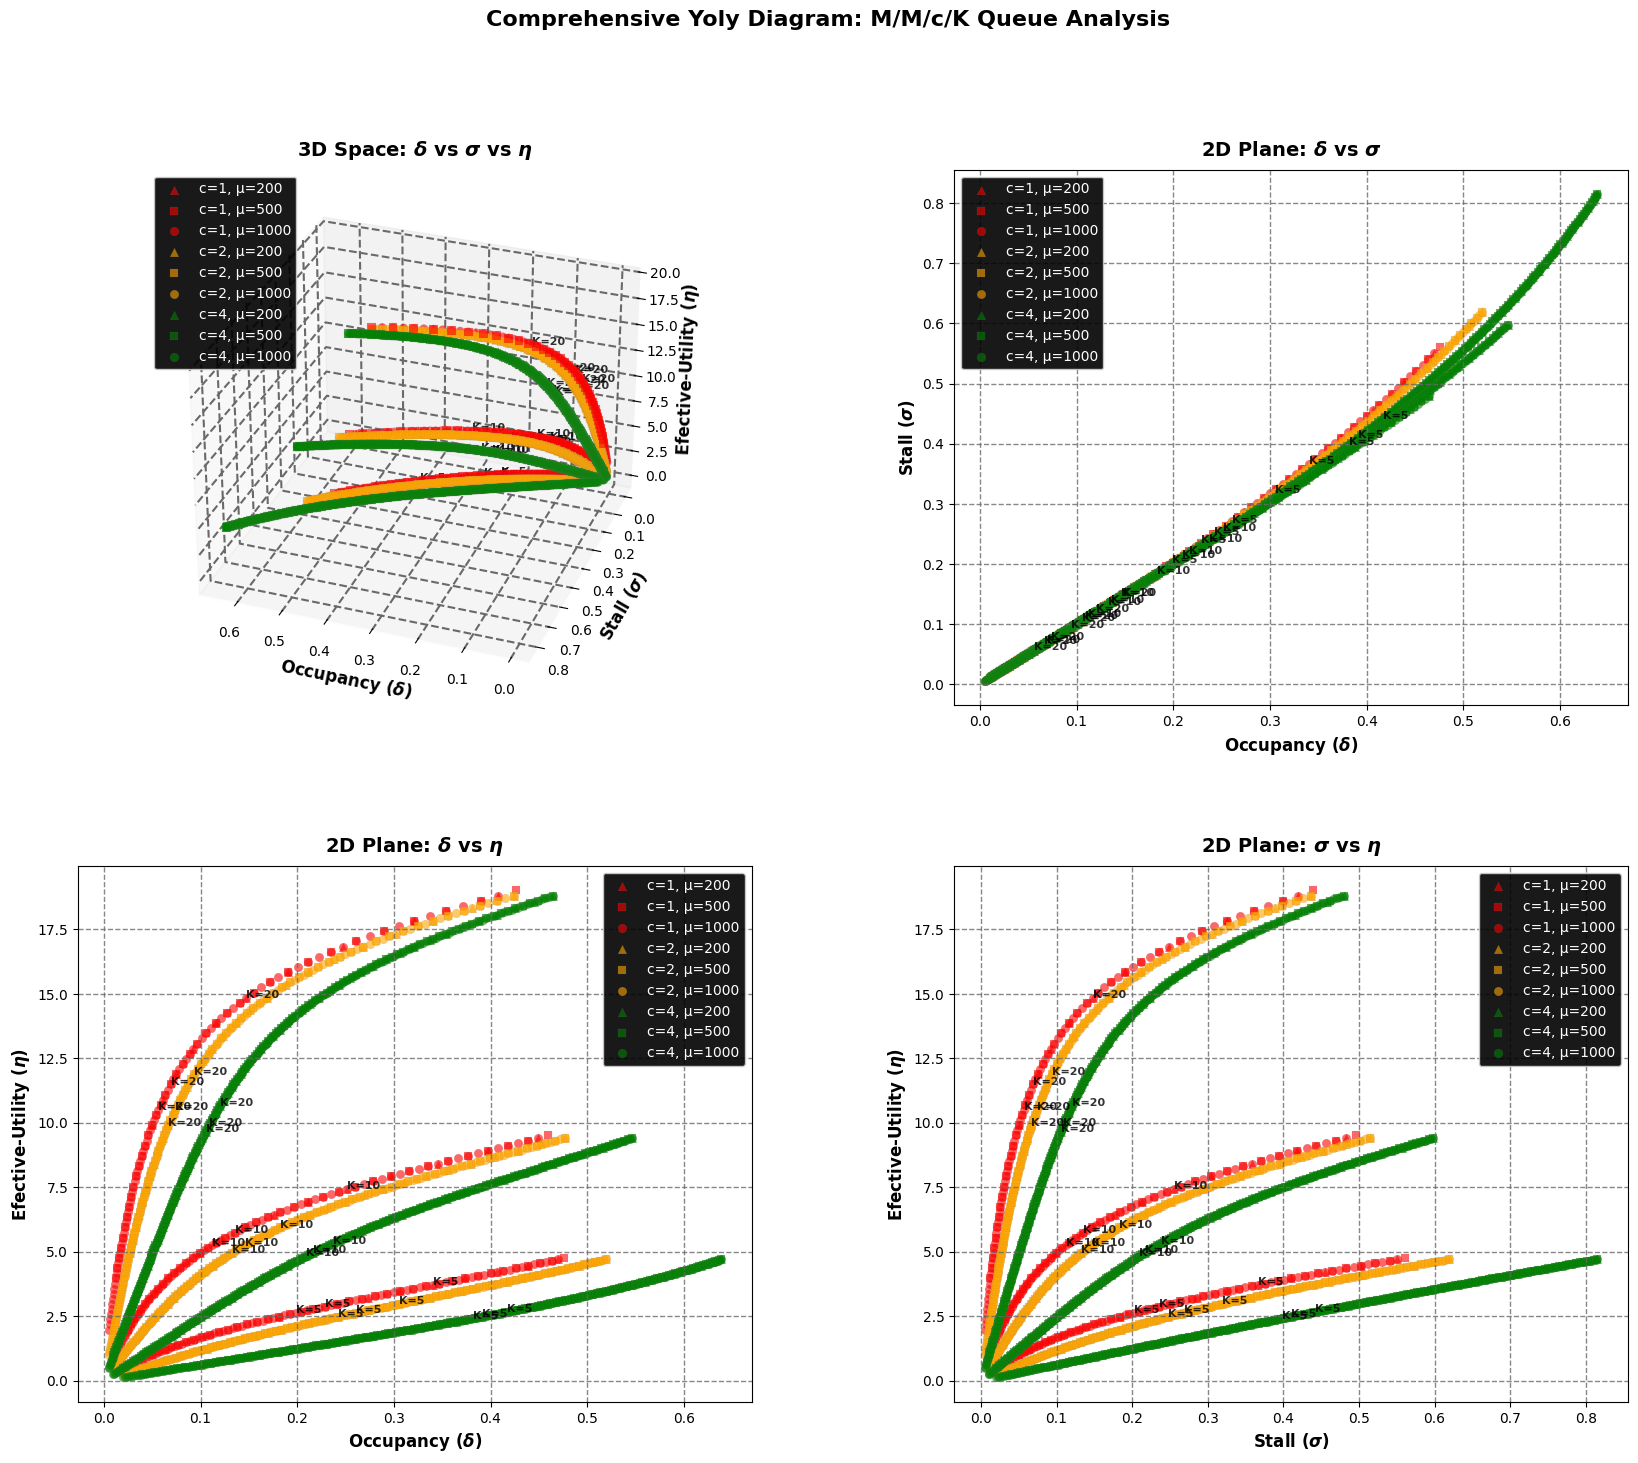

In [33]:
# Create comprehensive Yoly diagram with 3D and 2D projections in a 2x2 grid
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 16), facecolor="white")

# Define grid specification for 2x2 layout
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Create axes: [0,0] is 3D, others are 2D
axes = [
    [fig.add_subplot(gs[0, 0], projection="3d"), fig.add_subplot(gs[0, 1])],
    [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]
]

# Auxiliary lists for plot configuration
plot_types = ["3D", "2D", "2D", "2D"]
plot_titles = [
    r"3D Space: $\boldsymbol{\delta}$ vs $\boldsymbol{\sigma}$ vs $\boldsymbol{\eta}$",
    r"2D Plane: $\boldsymbol{\delta}$ vs $\boldsymbol{\sigma}$",
    r"2D Plane: $\boldsymbol{\delta}$ vs $\boldsymbol{\eta}$",
    r"2D Plane: $\boldsymbol{\sigma}$ vs $\boldsymbol{\eta}$"
]

x_labels = [
    r"Occupancy ($\boldsymbol{\delta}$)",
    r"Occupancy ($\boldsymbol{\delta}$)",
    r"Occupancy ($\boldsymbol{\delta}$)",
    r"Stall ($\boldsymbol{\sigma}$)"
]

y_labels = [
    r"Stall ($\boldsymbol{\sigma}$)",
    r"Stall ($\boldsymbol{\sigma}$)",
    r"Efective-Utility ($\boldsymbol{\eta}$)",
    r"Efective-Utility ($\boldsymbol{\eta}$)"
]

z_labels = [r"Efective-Utility ($\boldsymbol{\eta}$)", None, None, None]

# Data pairs for each subplot: (x_data, y_data, z_data or None)
data_pairs = [
    (delta_sim, sigma_sim, eta_sim),    # 3D plot
    (delta_sim, sigma_sim, None),       # delta vs sigma
    (delta_sim, eta_sim, None),         # delta vs eta
    (sigma_sim, eta_sim, None)          # sigma vs eta
]

# Color map for server count (c) and marker map for service rates (μ)
c_data = np.array(variables["c"].data)
mu_data = np.array(variables["\\mu_{s}"].data)
K_data = np.array(variables["K"].data)
unique_c = np.unique(c_data)
unique_mu = np.unique(mu_data)
unique_K = np.unique(K_data)

# Colors for servers: red (1), orange (2), green (4)
color_map = {1.0: "red", 2.0: "orange", 4.0: "green"}
# Markers for service rate: triangle (slow), square (mid), circle (fast)
marker_map = {200: "^", 500: "s", 1000: "o"}

# Iterate over 2x2 grid
plot_idx = 0
for row in range(2):
    for col in range(2):
        ax = axes[row][col]
        plot_type = plot_types[plot_idx]
        x_data, y_data, z_data = data_pairs[plot_idx]
        
        # Set white background for subplot
        ax.set_facecolor("white")
        
        # Track which (c, μ) combinations have been labeled for legend
        labeled_combinations = set()
        
        # Plot data points grouped by server count (c), service rate (μ), and capacity (K)
        for c_val in unique_c:
            for mu_val in unique_mu:
                for K_val in unique_K:
                    # Create mask for this specific combination
                    mask = (np.abs(c_data - c_val) < 0.1) & (np.abs(mu_data - mu_val) < 0.1) & (np.abs(K_data - K_val) < 0.1)
                    if not np.any(mask):
                        continue
                    
                    # Create label only once per (c, μ) combination
                    combo_key = (c_val, mu_val)
                    if combo_key not in labeled_combinations:
                        label = f"c={int(c_val)}, μ={int(mu_val)}"
                        labeled_combinations.add(combo_key)
                    else:
                        label = None  # No label for subsequent K values
                    
                    color = color_map.get(c_val, "gray")
                    marker = marker_map.get(mu_val, "o")
                    
                    if plot_type == "3D":
                        # 3D scatter plot
                        ax.scatter(x_data[mask], y_data[mask], z_data[mask],
                                   c=color, marker=marker, s=40, alpha=0.6,
                                   edgecolors="grey", linewidths=0.1,
                                   label=label)
                        # Add ONE K value label at median position of this cluster
                        mask_indices = np.where(mask)[0]
                        if len(mask_indices) > 0:
                            mid_idx = mask_indices[len(mask_indices)//2]
                            ax.text(x_data[mid_idx], y_data[mid_idx], z_data[mid_idx], 
                                    f"K={int(K_val)}", fontsize=8, color="black", 
                                    fontweight="bold", alpha=0.8)
                    else:
                        # 2D scatter plot
                        ax.scatter(x_data[mask], y_data[mask],
                                   c=color, marker=marker, s=40, alpha=0.6,
                                   edgecolors="grey", linewidths=0.1,
                                   label=label)
                        # Add ONE K value label at median position of this cluster
                        mask_indices = np.where(mask)[0]
                        if len(mask_indices) > 0:
                            mid_idx = mask_indices[len(mask_indices)//2]
                            ax.text(x_data[mid_idx], y_data[mid_idx], 
                                    f"K={int(K_val)}", fontsize=8, color="black", 
                                    fontweight="bold", alpha=0.8)
        
        # Apply plot-specific styling after all data points are plotted
        if plot_type == "3D":
            ax.set_zlabel(z_labels[plot_idx],
                          fontsize=12, fontweight="bold",
                          color="black")
            ax.view_init(elev=30, azim=110)
            
            # Enable 3D grid with explicit settings for each axis
            ax.grid(True, color="dimgray", linewidth=1.5, linestyle="--", alpha=0.9)
            ax.xaxis._axinfo["grid"]["color"] = "dimgray"
            ax.xaxis._axinfo["grid"]["linewidth"] = 1.5
            ax.xaxis._axinfo["grid"]["linestyle"] = "--"
            ax.yaxis._axinfo["grid"]["color"] = "dimgray"
            ax.yaxis._axinfo["grid"]["linewidth"] = 1.5
            ax.yaxis._axinfo["grid"]["linestyle"] = "--"
            ax.zaxis._axinfo["grid"]["color"] = "dimgray"
            ax.zaxis._axinfo["grid"]["linewidth"] = 1.5
            ax.zaxis._axinfo["grid"]["linestyle"] = "--"
            
            # Black tick parameters for 3D
            ax.tick_params(axis="x", colors="black")
            ax.tick_params(axis="y", colors="black")
            ax.tick_params(axis="z", colors="black")
        else:
            # 2D styling
            ax.grid(True, alpha=0.8,
                    color="dimgray", linewidth=1.0, linestyle="--")
            ax.tick_params(colors="black", which="both")
            for spine in ax.spines.values():
                spine.set_edgecolor("black")
        
        # Set labels and title with black font
        ax.set_xlabel(x_labels[plot_idx], fontsize=12, fontweight="bold", color="black")
        ax.set_ylabel(y_labels[plot_idx], fontsize=12, fontweight="bold", color="black")
        ax.set_title(plot_titles[plot_idx], fontsize=14, fontweight="bold", pad=10, color="black")
        ax.legend(loc="best", fontsize=10, framealpha=0.9)
        
        plot_idx += 1

# Add main title with black font
fig.suptitle("Comprehensive Yoly Diagram: M/M/c/K Queue Analysis\n",
             fontsize=16, fontweight="bold", y=0.98, color="black")
plt.show()


In [34]:

# Print summary statistics
print("=" * 100)
print("COMPREHENSIVE YOLY DIAGRAM STATISTICS")
print("=" * 100)
print(f"{'Metric':<30} {'Mean':<15} {'Std Dev':<15} {'Min':<15} {'Max':<15}")
print("-" * 100)
print(f"{'Occupancy Coefficient (δ)':<30} {np.mean(delta_sim):<15.4f} {np.std(delta_sim):<15.4f} {np.min(delta_sim):<15.4f} {np.max(delta_sim):<15.4f}")
print(f"{'Stall Coefficient (σ)':<30} {np.mean(sigma_sim):<15.4f} {np.std(sigma_sim):<15.4f} {np.min(sigma_sim):<15.4f} {np.max(sigma_sim):<15.4f}")
print(f"{'Efective-Utility Coefficient (η)':<30} {np.mean(eta_sim):<15.4f} {np.std(eta_sim):<15.4f} {np.min(eta_sim):<15.4f} {np.max(eta_sim):<15.4f}")
print("=" * 100)
print(f"\nConfiguration Distribution:")
print(f"{'Servers (c)':<15} {'Service Rate (μ)':<20} {'Capacity (K)':<15} {'Marker':<10} {'Color':<10} {'Count':<10} {'Percentage':<10}")
print("-" * 100)
for c_val in unique_c:
    for mu_val in unique_mu:
        for K_val in unique_K:
            mask = (np.abs(c_data - c_val) < 0.1) & (np.abs(mu_data - mu_val) < 0.1) & (np.abs(K_data - K_val) < 0.1)
            count = np.sum(mask)
            if count > 0:
                marker = marker_map.get(mu_val, "o")
                marker_name = {"^": "Triangle", "s": "Square", "o": "Circle"}.get(marker, "Unknown")
                color_name = {1.0: "Red", 2.0: "Orange", 4.0: "Green"}.get(c_val, "Gray")
                percentage = 100 * count / len(mu_data)
                print(f"{int(c_val):<15} {int(mu_val):<20} {int(K_val):<15} {marker_name:<10} {color_name:<10} {count:<10} {percentage:.1f}%")
print("=" * 100)

COMPREHENSIVE YOLY DIAGRAM STATISTICS
Metric                         Mean            Std Dev         Min             Max            
----------------------------------------------------------------------------------------------------
Occupancy Coefficient (δ)      0.2222          0.1677          0.0050          0.6387         
Stall Coefficient (σ)          0.2357          0.1919          0.0050          0.8153         
Efective-Utility Coefficient (η) 5.8899          4.6285          0.1237          19.0080        

Configuration Distribution:
Servers (c)     Service Rate (μ)     Capacity (K)    Marker     Color      Count      Percentage
----------------------------------------------------------------------------------------------------
1               200                  5               Triangle   Red        10         0.3%
1               200                  10              Triangle   Red        10         0.3%
1               200                  20              Triangle   Red   

## 11. Summary and Key Takeaways

### What We Accomplished

This notebook demonstrated PyDASA's dimensional analysis workflows applied to queueing theory and software service analysis using the M/M/c/K queue model:

1. **Custom Dimensional Framework**: Created a specialized framework with three fundamental dimensions (T, S, D) for software service analysis - Time, Structure, and Data.
2. **Variable Definition**: Defined 10 queue system variables including arrival rate (λ), service rate (μ), queue capacity (K), servers (c), and error rate (err).
3. **Dimensional Analysis**: Automatically derived 6 dimensionless Pi groups using Buckingham Pi theorem with custom dimensions.
4. **Coefficient Derivation**: Created operationally meaningful coefficients from Pi groups:
   - **δ** (Occupancy): L/K - Queue capacity utilization.
   - **σ** (Stall): W·λ/L - Service blocking indicator.
   - **η** (Efective-Utility): χ·K/(μ·c) - Resource utilization effectiveness.
   - **φ** (Payload): B/(ρ_req·K) - Data density metric.
5. **Sensitivity Analysis**: Symbolic analysis showing which variables most influence each dimensionless coefficient.
6. **Grid-Based Monte Carlo**: Generated structured data points systematically varying:
   - Queue capacity (K): [5, 10, 20] → 3 values
   - Service rate (μ): [200, 500, 1000] req/s → 3 values  
   - Server count (c): [1, 2, 4] → 3 values
   - Total: 3 × 3 × 3 = **27 configurations**
   - Constants: err = 1%, B = 1.28×10⁸ bits, ρ_req = 8×10⁶ bits/req
7. **Visualization**: Created comprehensive visualizations including:
   - **2×2 histogram grid**: Distribution plots for all four derived coefficients (δ, σ, η, φ) with LaTeX-formatted symbols and mean lines.
   - **Comprehensive Yoly diagram (2×2 grid)**:
     - 3D scatter plot (δ vs σ vs η) with server-based color coding and K-value labels.
     - Three 2D projection plots showing relationships between coefficient pairs:
       - δ vs σ (Occupancy vs Stall).
       - δ vs η (Occupancy vs Efective-Utility).
       - σ vs η (Stall vs Efective-Utility).

### Key PyDASA Workflows

```python
# 1. Custom Schema Definition
schema = Schema(_fwk="CUSTOM", _fdu_lt=fdu_list, ...)
schema._setup_fdus()

# 2. Dimensional Analysis
engine = AnalysisEngine(_fwk="CUSTOM", _schema=schema, ...)
engine.run_analysis()

# 3. Derive Coefficients
delta_coeff = engine.derive_coefficient(
    expr=f"{pi_keys[0]}", 
    symbol="\\delta",
    name="Occupancy Coefficient", ...)

# 4. Sensitivity Analysis
sensitivity = SensitivityAnalysis(_cat="SYM", ...)
sensitivity_results = sensitivity.analyze_symbolic(val_type="mean")

# 5. Monte Carlo Simulation
mc_grid = MonteCarloSimulation(
    _cat="DATA",  # Use actual data from grid search
    _experiments=len(data_df), ...)
mc_grid.run_simulation(iters=len(data_df))
```

### Features Demonstrated

✓ Custom dimensional frameworks beyond physical dimensions.  
✓ Software/service system dimensional analysis.  
✓ Queueing theory (M/M/c/K) integration with PyDASA.  
✓ Grid-based systematic data generation with 27 configurations.  
✓ Coefficient derivation with symbolic expressions.  
✓ Symbolic sensitivity analysis.  
✓ 3D and 2D visualization with matplotlib.  

### Key Insights

**Grid Search Configuration:**
- **27 configurations** explored systematically by varying three critical parameters:
  - Queue capacity (K): 5, 10, 20 requests.
  - Service rate (μ): 200, 500, 1000 req/s (representing slow, medium, fast services)
  - Server count (c): 1, 2, 4 parallel servers.
- For each configuration, arrival rate (λ) swept from 100 req/s until near-saturation (ρ ≥ 0.95).
- Fixed error rate at 1% (QoS agreement level).

**Queue Behavior Analysis:**
- **Occupancy (δ) and Stall (σ)** show strong positive correlation across all configurations in accorance to Little's law.
- **Efective-Utility (η)** exhibits nonlinear relationship with occupancy, influenced by both server count and service rate.
- **Server scaling** (c=1→2→4) significantly impacts system behavior:
  - More servers reduce utilization per server.
  - Enable higher λ before saturation.
  - Improve overall system efficiency.
- **Capacity scaling** (K=5→10→20) affects occupancy coefficient directly:
  - Larger K reduces δ for same queue length L.
  - Provides more buffering capacity.
  - Visible as separate clusters in Yoly diagram.
- **Service rate variation** (μ=200→500→1000) determines throughput limits:
  - Higher μ enables more requests per server.
  - Reduces waiting times and stall probability.
  - ast servers can perform equally or worse that slow components, this can be seen by the different marker shapes overlaping in the same curve of the visualizations.

**Dimensionless Coefficients:**
- **Occupancy (δ = L/K)**: Queue utilization ratio (0 = empty, 1 = full).
  - Directly affected by K variation in grid search.
  - Independent of absolute system scale.
- **Stall (σ = W·λ/L)**: Service blocking indicator.
  - Captures delay-throughput relationship.
  - Higher values indicate congestion risk.
- **Efective-Utility (η = χ·K/(μ·c))**: Resource utilization effectiveness.
  - Accounts for error rate through χ.
  - Balances capacity, service rate, and parallelism.
- **Payload (φ = B/(ρ_req·K))**: Data density metric.
  - Represents buffer-to-capacity ratio.
  - As the requests have the same data payload they are not significant to the simulations.
  - Varies inversely with K since B and ρ_req are fixed.

**Yoly Diagram Interpretation:**
Similar to the Moody diagram for fluid mechanics, the Yoly diagram maps dimensionless queue coefficients to operating regimes, enabling system designers to:
- Predict service stall probability from occupancy levels.
- Compare efficiency across 27 different system configurations.
- Balance resource allocation (servers vs. capacity vs. service rate).
- Identify optimal operating regions in 3D coefficient space (δ, σ, η).
- Optimize for the "Yoly happiness metric" (performance + availability + efficiency + reliability).
- Distinguish configuration families by color (server count), shape (service rate), and labels (capacity).

**Practical Applications:**
- Use Yoly diagram to select optimal (K, c, μ) combination for given workload.
- Predict system behavior under varying arrival rates without re-simulation.
- Scale resources dimensionlessly: insights apply regardless of absolute request rates.
- Design QoS policies based on dimensionless thresholds (e.g., keep δ < 0.7, σ < 0.5).

### Next Steps

- Extend analysis to other queueing models (M/G/1, G/G/c, priority queues, etc.).
- Incorporate time-varying arrival rates and non-stationary behavior.
- Add cost-based optimization using dimensionless coefficients ($/request vs. η).
- Explore other custom frameworks (Security, Latency, Reliability dimensions).
- Apply to real-world service telemetry data from production systems.
- Investigate multi-objective optimization across all four coefficients (δ, σ, η, φ).
- Develop predictive models using dimensionless regression.

Check [PyDASA Documentation](https://pydasa.readthedocs.io) for advanced features and more examples.

---

**About this notebook**: Created to demonstrate PyDASA's dimensional analysis workflows applied to queueing theory and software service analysis using custom dimensional frameworks. The "Yoly" concept represents a composite metric for system happiness (performance + availability + efficiency). For more examples and documentation, visit [PyDASA on GitHub](https://github.com/DASA-Design/PyDASA) or [Read the Docs](https://pydasa.readthedocs.io).

### M/M/c/K System Diagram

```
                    ┌─────────────────────────────────────────────────────┐
                    │  M/M/c/K System (Capacity = K)                      │
                    │                                                     │
  Arrivals (λ)      │     Queue          Servers (μ)      Response (χ)    │
  [S/T]             │   ┌─┬─┬─┐                                           │
                    │   │ │ │ │                                           │
    ● ● ●  ─────────┼──→│ │ │ │─────→  Server 1 (μ) ────────────────────→ ●    Served
    ● ● ●           │   └─┴─┴─┘    ╱                                      │  Requests
    ● ● ●           │    (K-c)    ╱                                       │  χ = (1-err)·λ
  (Poisson)         │   slots    ●─────→  Server 2 (μ) ───────────────→ ● │  [S/T]
                    │           ╲                                         │
  When FULL:        │            ╲                                        │
    ● ● ●  ─────X   │             ────→  Server c (μ) ─────────────────→ ●│
                    │                                                     │
  Blocked/          │  ↑____________________________________________↑     │
  Rejected          │         K = Total Capacity (queue + servers)        │
                    │                                                     │
  Error Rate (err)  │  Note: χ = (1 - err) · λ                            │
  Affects Response  │  Some requests fail → reduces effective throughput  │
  [%]               │                                                     │
                    └─────────────────────────────────────────────────────┘
                    
  Legend:
  - λ (lambda): Arrival rate [S/T]
  - μ (mu): Service rate per server [S/T]
  - c: Number of parallel servers [S]
  - K: Total capacity (queue + servers) [S]
  - χ (chi): Effective response rate = (1 - err) · λ [S/T]
  - err: Error/failure rate [%, 0 to 1]
```